# Data Exploration / Testing Algorithms

Dataset: https://snap.stanford.edu/data/soc-RedditHyperlinks.html

Political subreddits list: https://github.com/valentinhofmann/politosphere/blob/main/data/subreddits.txt


## Dataset information
- **SOURCE_SUBREDDIT**: the subreddit where the link originates
- **TARGET_SUBREDDIT**: the subreddit where the link ends
- **POST_ID**: the post in the source subreddit that starts the link
- **TIMESTAMP**: time time of the post
- **POST_LABEL**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.
- **POST_PROPERTIES**: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:
1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER

22-86. LIWC Variables

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

In [9]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

In [10]:
df_full

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
...,...,...,...,...,...,...
286556,negareddit,debatefascism,68im20s,2017-04-30 16:31:26,1,"441.0,405.0,0.775510204082,0.0294784580499,0.0..."
286557,mildlynomil,justnomil,68imlas,2017-04-30 04:19:03,1,"2226.0,1855.0,0.786163522013,0.00224618149146,..."
286558,mmorpg,blackdesertonline,68ip5os,2017-04-30 16:54:08,1,"1100.0,909.0,0.778181818182,0.00181818181818,0..."
286559,electricskateboards,askreddit,68ipb2s,2017-04-30 16:41:53,1,"1876.0,1567.0,0.78144989339,0.00692963752665,0..."


In [12]:
import re

# Read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|justice|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)
political_subs = list(set(political_subs))

source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only rows where both source and target are political
df = df_full[source_is_political & target_is_political]

In [13]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
360,metaconservative,conservative,1uf4qp,2014-01-04 14:50:38,-1,"769.0,658.0,0.788036410923,0.00130039011704,0...."
362,libertarian,conservative,1uf53xs,2014-01-04 14:41:05,1,"739.0,633.0,0.794316644114,0.00135317997294,0...."
530,libertariancopypasta,politicaldiscussion,1ujbnhs,2014-01-06 12:33:49,1,"1643.0,1383.0,0.793061472915,0.00182592818016,..."
547,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0...."
962,mensrightsmeta,mensrights,1urzs0s,2014-01-15 11:33:58,1,"559.0,471.0,0.75313059034,0.00357781753131,0.0..."
...,...,...,...,...,...,...
285825,enough_sanders_spam,enoughsandersspam,67zs07,2017-04-27 17:34:00,-1,"783.0,681.0,0.757343550447,0.0204342273308,0.0..."
285846,modelussenate,modelsenatefinancecom,68051ns,2017-04-27 18:44:31,1,"109.0,107.0,0.733944954128,0.0642201834862,0.0..."
285866,neoliberal,badeconomics,680xo6s,2017-04-27 21:36:40,1,"1506.0,1309.0,0.750332005312,0.0152722443559,0..."
286055,devotedmap,devoted,685nnas,2017-04-28 17:39:18,1,"1570.0,1508.0,0.269426751592,0.373885350318,0...."


In [14]:
df.to_csv("filtered_network.csv", index=False)

In [15]:
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
# convert to adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G, weight="count")

In [16]:
adj_matrix

,metaconservative,conservative,libertarian,libertariancopypasta,politicaldiscussion,communism101,communism,mensrightsmeta,mensrights,politics,...,shitlibertariansay,neoliberal,theredpillright,holocaust,bernie_sanders,georgism,politicalrevolutionpa,modelussenate,modelsenateenvirocom,modelsenatefinancecom
metaconservative,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
conservative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
libertarian,0.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,16.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
libertariancopypasta,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
politicaldiscussion,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
georgism,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
politicalrevolutionpa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
modelussenate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
modelsenateenvirocom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of communities detected: 19
Sample of nodes and their communities: [('metaconservative', 6), ('conservative', 6), ('libertarian', 18), ('libertariancopypasta', 18), ('politicaldiscussion', 11), ('communism101', 8), ('communism', 8), ('mensrightsmeta', 8), ('mensrights', 8), ('politics', 5)]


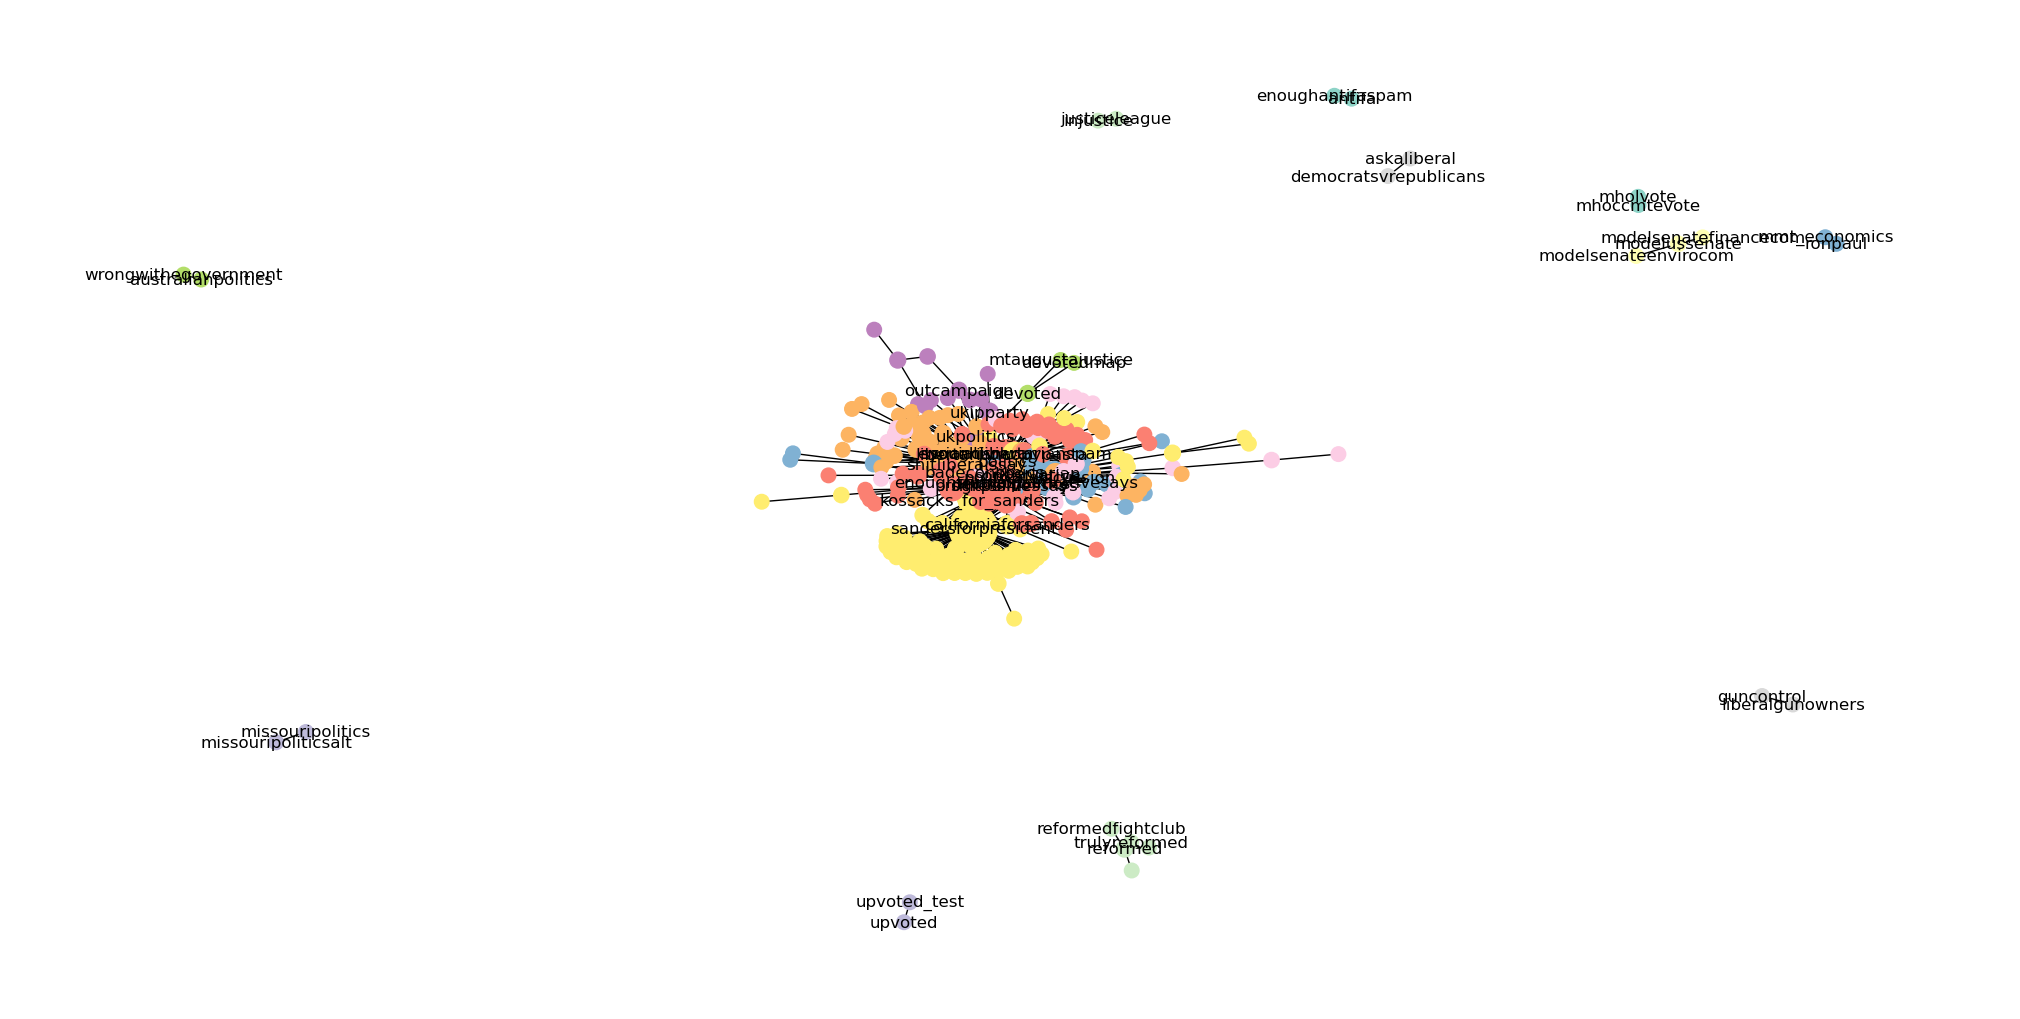

In [19]:
# Convert to undirected graph for Louvain method
G_undirected = G.to_undirected()

# Compute the best partition
partition = community_louvain.best_partition(G_undirected, weight='count')

nx.set_node_attributes(G, partition, 'community')

# calculate node sizes based on degree
node_sizes = [100 + 10 * G_undirected.degree(node) for node in G_undirected.nodes()]

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]
    
    for node in top_nodes:
        community_labels[node] = node  

print("Number of communities detected:", len(set(partition.values())))
print("Sample of nodes and their communities:", list(partition.items())[:10])

# Plot the communities with node size based on degree
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G_undirected)
colors = [partition[node] for node in G_undirected.nodes()]

# Draw the graph with variable node sizes and selective labels
nx.draw(G_undirected, pos, node_color=colors, node_size=node_sizes, labels=community_labels, cmap=plt.cm.Set3)
plt.show()


In [20]:
from collections import defaultdict

# Create a dictionary to store nodes for each community
communities = defaultdict(list)

# Populate the dictionary
for node, community in partition.items():
    communities[community].append(node)

# Now, `communities` contains a list of nodes for each community
for community, nodes in communities.items():
    print(f"Community {community}: {nodes}")

Community 6: ['metaconservative', 'conservative', 'liberal', 'shitrconservativesays', 'new_right', 'progun', 'climateskeptics', 'republican', 'prolife', 'prochoice', 'whiterights', 'shitpoliticssays', 'paleoconservative', 'gunpolitics', 'rconservativenews', 'conservatives_r_us', 'conservativemeta', 'isrconservativeracist', 'explainmydownvotes', 'conservatives', 'nevertrump', 'metarepublican', 'conservativesonly', 'thedavidpakmanshow', 'daverubin', 'georgism']
Community 18: ['libertarian', 'libertariancopypasta', 'enoughlibertarianspam', 'libertariandebates', 'randpaul', 'classicalliberal', 'classicalliberalparty', 'austrian_economics', 'actualconspiracies', 'libertarianmeme', 'newjerseylibertarians', 'demsocialist', 'libertarianpartyohio', 'libertarianpartyusa', 'calibertarians', 'acteuropa', 'antiwar', 'magajuana', 'shitlibertariansay', 'theredpillright']
Community 11: ['politicaldiscussion', 'postnationalist', 'politic', 'agitation', 'worldpolitics', 'geopolitics', 'syriancivilwar', 

In [27]:
community_sentiment = {}
in_sents = np.zeros(19)
out_sents = np.zeros(19)

for community, nodes in communities.items():
    source_in = df["SOURCE_SUBREDDIT"].isin(nodes)
    target_in = df["TARGET_SUBREDDIT"].isin(nodes)
    
    df_community = df[source_in & target_in]
    df_out_community = df[source_in & ~target_in]

    community_sentiment[community] = np.zeros(2)
    community_sentiment[community][0] = df_community['LINK_SENTIMENT'].mean()
    community_sentiment[community][1] = df_out_community['LINK_SENTIMENT'].mean()

for community, sentiments in community_sentiment.items():
    print(f"Community {community}: ")
    print(f"Within Community Sentiment: {sentiments[0]}")
    in_sents[community] = sentiments[0]
    
    print(f"Outside Community Sentiment: {sentiments[1]}")
    out_sents[community] = sentiments[1]
    print()

Community 6: 
Within Community Sentiment: 0.6761904761904762
Outside Community Sentiment: 0.6170212765957447

Community 18: 
Within Community Sentiment: 0.6888888888888889
Outside Community Sentiment: 0.5641025641025641

Community 11: 
Within Community Sentiment: 0.7684210526315789
Outside Community Sentiment: 0.8494623655913979

Community 8: 
Within Community Sentiment: 0.6058394160583942
Outside Community Sentiment: 0.6690140845070423

Community 5: 
Within Community Sentiment: 0.6808510638297872
Outside Community Sentiment: 0.7959183673469388

Community 7: 
Within Community Sentiment: 1.0
Outside Community Sentiment: nan

Community 14: 
Within Community Sentiment: 0.7209302325581395
Outside Community Sentiment: 1.0

Community 15: 
Within Community Sentiment: 1.0
Outside Community Sentiment: nan

Community 17: 
Within Community Sentiment: 0.9441860465116279
Outside Community Sentiment: 0.775

Community 3: 
Within Community Sentiment: 1.0
Outside Community Sentiment: nan

Community 4: 

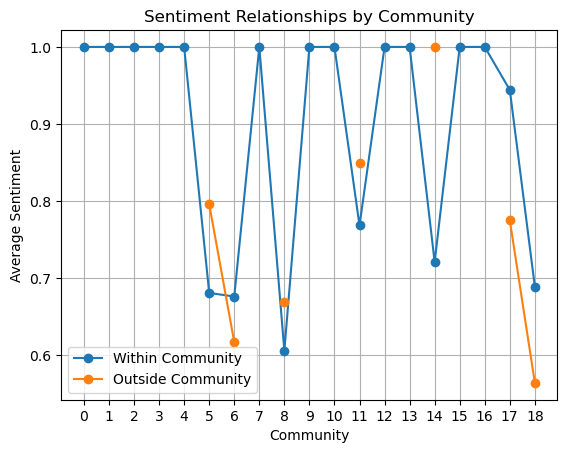

In [44]:
plt.plot(sorted(communities.keys()), in_sents, marker='o', label = 'Within Community')
plt.plot(sorted(communities.keys()), out_sents, marker='o', label = 'Outside Community')
plt.xticks(sorted(communities.keys()))
plt.grid()
plt.xlabel('Community')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Relationships by Community')
plt.legend()
plt.show()